In [1]:
from processing.preprocessing import BCIDataProcessor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score)
from scipy.stats import randint


recording_path = '../recordings/recording_imagery1_gel.raw.fif'
window_size = 2
window_overlap = 1
processor = BCIDataProcessor(recording_path, l_freq=7, h_freq=15, window_size=window_size,
                             window_overlap=window_overlap)
data = processor.process(psds=True, nfft=500)
# Only select left_hand and right_hand
data = {label: data[label] for label in data.keys() if label in ['relax', 'focus']}
data

{'relax': array([[[1.95478840e-12, 6.62110055e-12, 8.88357775e-12, ...,
          2.01104319e-12, 9.14927278e-13, 6.32996018e-13],
         [3.44756604e-12, 3.32868331e-12, 1.06215611e-12, ...,
          7.20800959e-13, 1.95352620e-12, 4.57491018e-13],
         [4.97630035e-13, 5.05192566e-12, 5.86337822e-12, ...,
          2.33143180e-13, 1.81062799e-12, 8.60300913e-13],
         ...,
         [1.51874334e-12, 6.80198736e-12, 8.34720812e-12, ...,
          4.20055028e-12, 2.53069781e-12, 1.06058726e-12],
         [9.99816106e-13, 8.38027111e-14, 5.67926228e-14, ...,
          4.04184038e-12, 1.87498493e-12, 4.58889113e-13],
         [2.60766033e-13, 7.16110412e-13, 4.31380663e-15, ...,
          1.53813750e-12, 6.92856610e-13, 1.52128108e-12]],
 
        [[1.37324535e-11, 1.97059719e-11, 3.69464295e-11, ...,
          5.11236358e-12, 6.48141612e-12, 6.83296895e-12],
         [2.56411635e-12, 5.47989391e-12, 1.28174329e-11, ...,
          7.75614533e-13, 9.16049128e-13, 1.68424536e-12]

In [2]:
X = np.concatenate(list(data.values()), axis=0)
X = X.reshape(X.shape[0], -1)  # Reshape to (samples, channels * features)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [3]:
X.shape, y.shape, X_trainval.shape, y_trainval.shape, X_test.shape, y_test.shape

((112, 136), (112,), (89, 136), (89,), (23, 136), (23,))

Best parameters found:  {'svc__C': np.float64(8.18397348116461), 'svc__degree': 2, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Training accuracy (CV avg):  0.8202614379084967
Accuracy: 0.7826
Precision (weighted): 0.7856
Recall (weighted): 0.7826
F1 Score (weighted): 0.7826


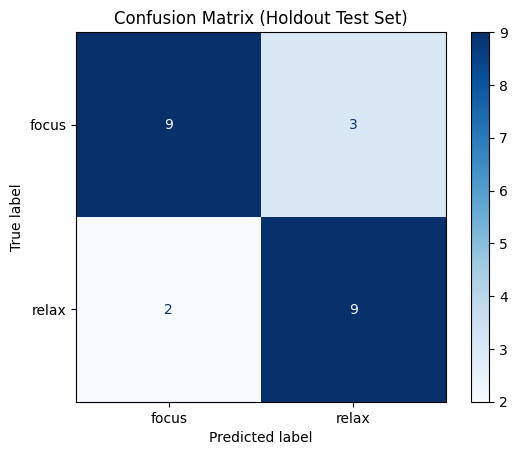

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score)
from scipy.stats import uniform

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42))
])

param_dist = {
    'svc__C': uniform(0.1, 10),          # Regularization strength
    'svc__gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 6)),  # Kernel coefficient
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],  # Different kernel types
    'svc__degree': [2, 3, 4],            # Only relevant if kernel='poly'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_trainval, y_trainval)

best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)
print("Training accuracy (CV avg): ", random_search.best_score_)

y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Holdout Test Set)")
plt.show()